In [1]:
import pandas as pd
import datatable as dt
import numpy as np
import seaborn as sns
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import StratifiedKFold, cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, accuracy_score, precision_recall_fscore_support, precision_score, auc, recall_score, roc_auc_score, make_scorer, balanced_accuracy_score, confusion_matrix, ConfusionMatrixDisplay, RocCurveDisplay
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
from sklearn.pipeline import Pipeline
from nested_cross_val.base import NestedCV
from nested_cross_val.tools.plotting import plot_roc , plot_PR , plot_score , plot_hyperparameters

from dask.distributed import Client
client = Client(processes=False)
import time
import shap

import matplotlib.pyplot as plt

In [2]:
path_to_csv = r'/mnt/data/psteinmetz/neotex/CSV/TUMOUR.csv'
path_to_csv_ville = r'/mnt/data/psteinmetz/neotex/CSV/Tumour_ville.csv'

path_to_csv_ozgun = r'/mnt/data/psteinmetz/neotex/CSV/Tumour_testing2.csv'
path_to_csv_ozgun_target = r'/mnt/data/psteinmetz/neotex/CSV/Tumour_testing2.xlsx'

data_train = pd.concat((dt.fread(path_to_csv).to_pandas(), dt.fread(path_to_csv_ville).to_pandas()), ignore_index=True)

data_eval = dt.fread(path_to_csv_ozgun).to_pandas()
target_eval = pd.read_excel(path_to_csv_ozgun_target, sheet_name='Sheet2')

X_train_all = data_train.iloc[:, 127:-1]
X_eval_all = data_eval.iloc[:, 4:]

to_drop = X_train_all.columns.difference(X_eval_all.columns)

X_train_all_without_DCE = X_train_all.drop(to_drop, axis=1)

The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.


In [3]:
shape_target_train = data_train[['Shape.1']]
margins_target_train = data_train[['Margins (MR)']]

margins_target_train.loc[margins_target_train['Margins (MR)']== 'Circunscribed'] = 'Circumscribed'

shape_target_eval = target_eval[['mr_mass_shp.factor']]
margins_target_eval = target_eval[['mr_mass_mrg.factor']]

margins_target_eval.loc[margins_target_eval['mr_mass_mrg.factor']== 'Circunscribed'] = 'Circumscribed'


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [4]:
label_encoder_margins = LabelEncoder()
margins_target_train['Margins (MR)']= label_encoder_margins.fit_transform(margins_target_train['Margins (MR)']) 
margins_target_eval['mr_mass_mrg.factor']= label_encoder_margins.transform(margins_target_eval['mr_mass_mrg.factor'])

label_encoder_shape = LabelEncoder()
shape_target_train['Shape.1']= label_encoder_shape.fit_transform(shape_target_train['Shape.1']) 
shape_target_eval['mr_mass_shp.factor']= label_encoder_shape.transform(shape_target_eval['mr_mass_shp.factor'])

margins_target_train.loc[margins_target_train['Margins (MR)']==1, 'Margins (MR)'] = 0
margins_target_train.loc[margins_target_train['Margins (MR)']==2, 'Margins (MR)'] = 1

margins_target_eval.loc[margins_target_eval['mr_mass_mrg.factor']==1, 'mr_mass_mrg.factor'] = 0
margins_target_eval.loc[margins_target_eval['mr_mass_mrg.factor']==2, 'mr_mass_mrg.factor'] = 1

shape_target_train.loc[shape_target_train['Shape.1']==2, 'Shape.1'] = 1

shape_target_eval.loc[shape_target_eval['mr_mass_shp.factor']==2, 'mr_mass_shp.factor'] = 1


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/

In [16]:
pipe = Pipeline([('scaler', StandardScaler()), ('logistic', LogisticRegression(solver='saga', max_iter = 10000))])

In [19]:
skf_out = StratifiedKFold(n_splits=10, random_state=123, shuffle=True)
skf_in = StratifiedKFold(n_splits=5, random_state=123, shuffle=True)
params_grid = {
            'logistic__class_weight': [{0:0.05, 1:0.95}, {0:0.1, 1:0.9}, {0:0.2, 1:0.8}, {0:0.3, 1:0.7}, {0:0.4, 1:0.6}, {0:0.5, 1:0.5}],
            'logistic__penalty': ['elasticnet'],
            'logistic__C': np.logspace(-2, 1, 20),
            'logistic__l1_ratio' : np.arange(0 , 1.1 , 0.1)
                    }

ncv = NestedCV(estimator = pipe, params = params_grid , cv_inner = skf_in, cv_outer = skf_out, 
               scoring_inner = 'f1' , scoring_outer = {'roc_auc': 'roc_auc', 'balanced_accuracy': 'balanced_accuracy', 'precision': 'precision', 'recall': 'recall', 'f1': 'f1'},#, 'specificity': 'specificity', 'sensitivity': 'sensitivity'},
               library = 'dask' , scheduler = client, verbose=2, randomized=True)

In [20]:
start = time.time()
ncv.fit(X_train_all_without_DCE, shape_target_train.values.ravel())
end = time.time()
minutes, seconds = divmod(end - start, 60)
print("Total fitting time (min): " + "{:0>2}:{:05.2f}".format(int(minutes),seconds))

inner training out fold 0 done ! running time (min): 00:19.91
inner training out fold 1 done ! running time (min): 00:19.06
inner training out fold 2 done ! running time (min): 00:22.24
inner training out fold 3 done ! running time (min): 00:18.81
inner training out fold 4 done ! running time (min): 00:18.26
inner training out fold 5 done ! running time (min): 00:17.99
inner training out fold 6 done ! running time (min): 00:18.70
inner training out fold 7 done ! running time (min): 00:21.80
inner training out fold 8 done ! running time (min): 00:21.20
inner training out fold 9 done ! running time (min): 00:27.19
Total fitting time (min): 03:46.10


The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge


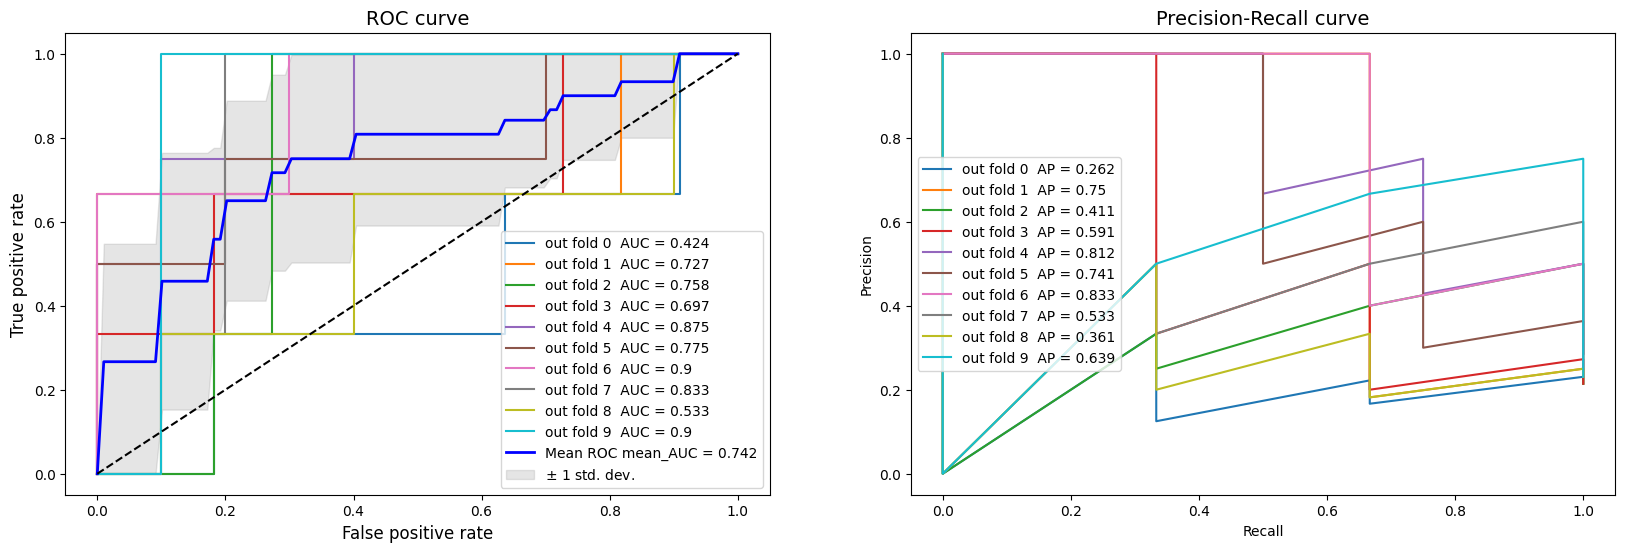

In [23]:
fig , axes = plt.subplots(1 , 2 , figsize = (20, 6))
plot_roc(ncv , ax = axes[0])
plot_PR(ncv , ax = axes[1])

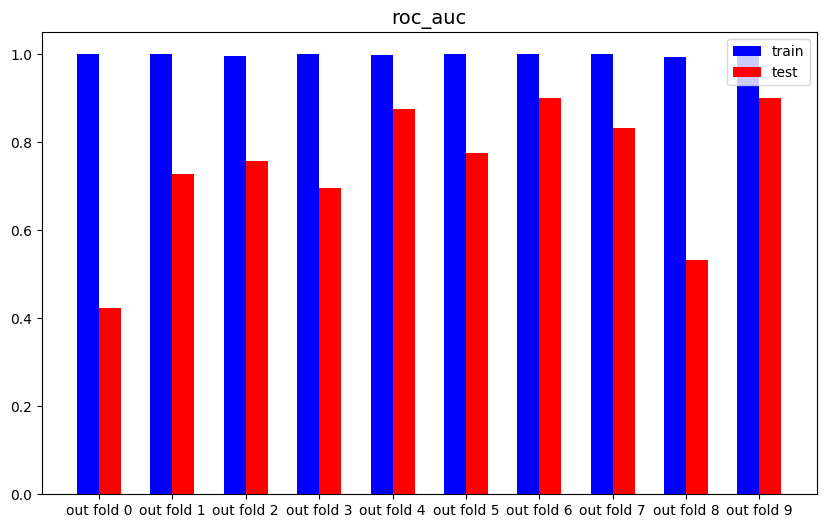

In [24]:
plot_score(ncv , score_name = 'roc_auc' , display = 'barplot')

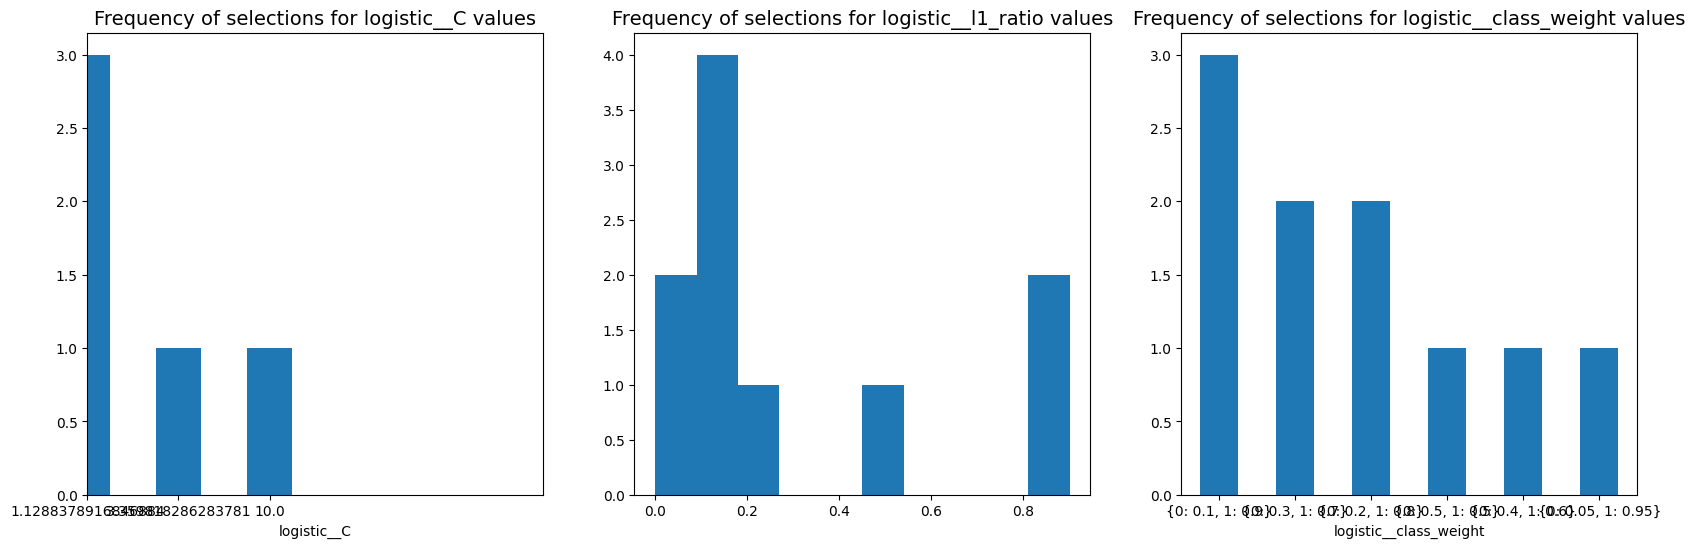

In [31]:
fig , ax = plt.subplots(1 , 3 , figsize = (20 , 6))
plot_hyperparameters(ncv , name = 'logistic__C' , ax = ax[0])
ax[0].set_xlim([5, 10])
plot_hyperparameters(ncv , name = 'logistic__l1_ratio' , discrete = False , ax = ax[1])
plot_hyperparameters(ncv , name = 'logistic__class_weight' ,  ax = ax[2])


In [39]:
ncv.best_params_

[{'logistic__penalty': 'elasticnet',
  'logistic__l1_ratio': 0.9,
  'logistic__class_weight': {0: 0.5, 1: 0.5},
  'logistic__C': 10.0},
 {'logistic__penalty': 'elasticnet',
  'logistic__l1_ratio': 0.1,
  'logistic__class_weight': {0: 0.1, 1: 0.9},
  'logistic__C': 0.2636650898730358},
 {'logistic__penalty': 'elasticnet',
  'logistic__l1_ratio': 0.1,
  'logistic__class_weight': {0: 0.1, 1: 0.9},
  'logistic__C': 0.12742749857031335},
 {'logistic__penalty': 'elasticnet',
  'logistic__l1_ratio': 0.5,
  'logistic__class_weight': {0: 0.4, 1: 0.6},
  'logistic__C': 3.359818286283781},
 {'logistic__penalty': 'elasticnet',
  'logistic__l1_ratio': 0.0,
  'logistic__class_weight': {0: 0.3, 1: 0.7},
  'logistic__C': 0.01},
 {'logistic__penalty': 'elasticnet',
  'logistic__l1_ratio': 0.1,
  'logistic__class_weight': {0: 0.05, 1: 0.95},
  'logistic__C': 1.1288378916846884},
 {'logistic__penalty': 'elasticnet',
  'logistic__l1_ratio': 0.1,
  'logistic__class_weight': {0: 0.1, 1: 0.9},
  'logistic__C

In [40]:
new_pipe = Pipeline([('scaler', StandardScaler()), ('logistic', LogisticRegression(solver='saga', C=0.5, l1_ratio=0.1, penalty='elasticnet', class_weight= {0:0.1, 1:0.9},  max_iter = 10000))])

In [41]:
new_pipe.fit(X_train_all_without_DCE, shape_target_train.values.ravel()).score(X_eval_all, shape_target_eval.values.ravel())

0.72

In [16]:
def compute_pred(model, X_test):
    return model.predict(X_test)

Pipeline(steps=[('scaler', StandardScaler()),
                ('logistic',
                 LogisticRegression(C=0.5, class_weight={0: 0.1, 1: 0.9},
                                    l1_ratio=0.1, max_iter=10000,
                                    penalty='elasticnet', solver='saga'))])
sensitivity: 0.9230769230769231
specificity: 0.6486486486486487
youden_index: 0.5717255717255718
balanced_accuracy: 0.7858627858627859
roc_auc: 0.7858627858627859
precision: 0.48
recall: 0.9230769230769231
              precision    recall  f1-score   support

           0       0.96      0.65      0.77        37
           1       0.48      0.92      0.63        13

    accuracy                           0.72        50
   macro avg       0.72      0.79      0.70        50
weighted avg       0.84      0.72      0.74        50



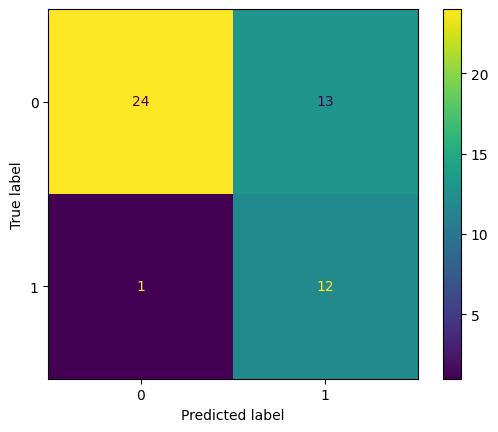

In [46]:
for model in [new_pipe]:
    scoring = {
    'sensitivity': make_scorer(recall_score),
    'specificity': make_scorer(recall_score,pos_label=0),
    'balanced_accuracy': make_scorer(balanced_accuracy_score),
    'roc_auc': make_scorer(roc_auc_score),
    'precision': make_scorer(precision_score),
    'recall': make_scorer(recall_score),
    'precision_recall_f': make_scorer(precision_recall_fscore_support)
    }

    if model == new_pipe:
        y_pred = compute_pred(model, X_eval_all)
        print(model)
        print('sensitivity: ' + str(scoring['sensitivity'](model, X_eval_all, shape_target_eval)))
        print('specificity: ' + str(scoring['specificity'](model, X_eval_all, shape_target_eval)))
        print('youden_index: ' + str(scoring['specificity'](model, X_eval_all, shape_target_eval)+ scoring['sensitivity'](model, X_eval_all, shape_target_eval) - 1))
        print('balanced_accuracy: ' + str(scoring['balanced_accuracy'](model, X_eval_all, shape_target_eval)))
        print('roc_auc: ' + str(scoring['roc_auc'](model, X_eval_all, shape_target_eval)))
        print('precision: ' + str(scoring['precision'](model, X_eval_all, shape_target_eval)))
        print('recall: ' + str(scoring['recall'](model, X_eval_all, shape_target_eval)))

        print(classification_report(shape_target_eval.values.ravel(), y_pred))
        cm = confusion_matrix(shape_target_eval.values.ravel(), y_pred, labels=model.classes_)
        disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                                    display_labels=model.classes_)
        disp.plot()
    

In [92]:
skf = StratifiedKFold(n_splits=5, random_state=123, shuffle=True)
params_grid = {
            'logistic__class_weight': [{0:0.05, 1:0.95}, {0:0.1, 1:0.9}, {0:0.2, 1:0.8}],# {0:0.3, 1:0.7}, {0:0.4, 1:0.6}, {0:0.5, 1:0.5}],
            'logistic__penalty': ['elasticnet'],
            'logistic__C': np.logspace(-2, 0.5, 20),
            'logistic__l1_ratio' : np.arange(0 , 1.1 , 0.1)
                    }
optimized_new_pipe = Pipeline([('scaler', StandardScaler()), ('logistic', LogisticRegression(solver='saga', max_iter = 100000))])
search = GridSearchCV(optimized_new_pipe, params_grid, cv=skf, n_jobs=-1, verbose=1, scoring='f1')
search.fit(X_train_all_without_DCE, shape_target_train.values.ravel())

Fitting 5 folds for each of 660 candidates, totalling 3300 fits


GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=123, shuffle=True),
             estimator=Pipeline(steps=[('scaler', StandardScaler()),
                                       ('logistic',
                                        LogisticRegression(max_iter=100000,
                                                           solver='saga'))]),
             n_jobs=-1,
             param_grid={'logistic__C': array([0.01      , 0.01353876, 0.01832981, 0.02481629, 0.03359818,
       0.04548778, 0.06158482, 0.08337822, 0.11288379, 0.15283067,
       0.20691381, 0.28013568, 0.37926902, 0.51348329, 0.6951928 ,
       0.94120497, 1.27427499, 1.72521055, 2.33572147, 3.16227766]),
                         'logistic__class_weight': [{0: 0.05, 1: 0.95},
                                                    {0: 0.1, 1: 0.9},
                                                    {0: 0.2, 1: 0.8}],
                         'logistic__l1_ratio': array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
                         'logistic__penalty': ['elasticnet']},
             scoring='f1', verbose=1)

In [93]:
search.best_params_

{'logistic__C': 1.7252105499420407,
 'logistic__class_weight': {0: 0.1, 1: 0.9},
 'logistic__l1_ratio': 0.30000000000000004,
 'logistic__penalty': 'elasticnet'}

Pipeline(steps=[('scaler', StandardScaler()),
                ('logistic',
                 LogisticRegression(C=1.7252105499420407,
                                    class_weight={0: 0.1, 1: 0.9},
                                    l1_ratio=0.30000000000000004,
                                    max_iter=100000, penalty='elasticnet',
                                    solver='saga'))])
sensitivity: 0.8461538461538461
specificity: 0.6756756756756757
youden_index: 0.5218295218295217
balanced_accuracy: 0.7609147609147608
roc_auc: 0.760914760914761
precision: 0.4782608695652174
recall: 0.8461538461538461
              precision    recall  f1-score   support

           0       0.93      0.68      0.78        37
           1       0.48      0.85      0.61        13

    accuracy                           0.72        50
   macro avg       0.70      0.76      0.70        50
weighted avg       0.81      0.72      0.74        50



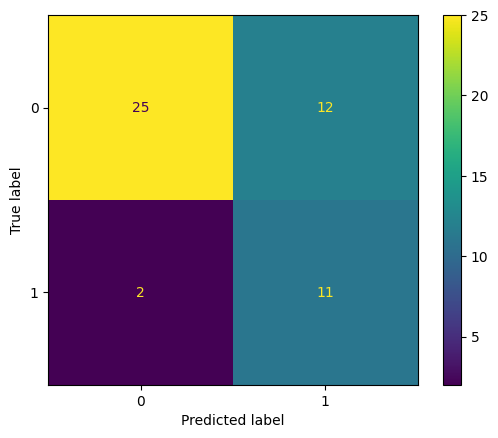

In [94]:
for model in [search.best_estimator_]:
    scoring = {
    'sensitivity': make_scorer(recall_score),
    'specificity': make_scorer(recall_score,pos_label=0),
    'balanced_accuracy': make_scorer(balanced_accuracy_score),
    'roc_auc': make_scorer(roc_auc_score),
    'precision': make_scorer(precision_score),
    'recall': make_scorer(recall_score),
    'precision_recall_f': make_scorer(precision_recall_fscore_support)
    }

    if model == search.best_estimator_:
        y_pred = compute_pred(model, X_eval_all)
        print(model)
        print('sensitivity: ' + str(scoring['sensitivity'](model, X_eval_all, shape_target_eval)))
        print('specificity: ' + str(scoring['specificity'](model, X_eval_all, shape_target_eval)))
        print('youden_index: ' + str(scoring['specificity'](model, X_eval_all, shape_target_eval)+ scoring['sensitivity'](model, X_eval_all, shape_target_eval) - 1))
        print('balanced_accuracy: ' + str(scoring['balanced_accuracy'](model, X_eval_all, shape_target_eval)))
        print('roc_auc: ' + str(scoring['roc_auc'](model, X_eval_all, shape_target_eval)))
        print('precision: ' + str(scoring['precision'](model, X_eval_all, shape_target_eval)))
        print('recall: ' + str(scoring['recall'](model, X_eval_all, shape_target_eval)))

        print(classification_report(shape_target_eval.values.ravel(), y_pred))
        cm = confusion_matrix(shape_target_eval.values.ravel(), y_pred, labels=model.classes_)
        disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                                    display_labels=model.classes_)
        disp.plot()

In [95]:
coeff_imp = pd.DataFrame(abs(search.best_estimator_['logistic'].coef_), columns=[X_train_all_without_DCE.columns])

<Axes: >

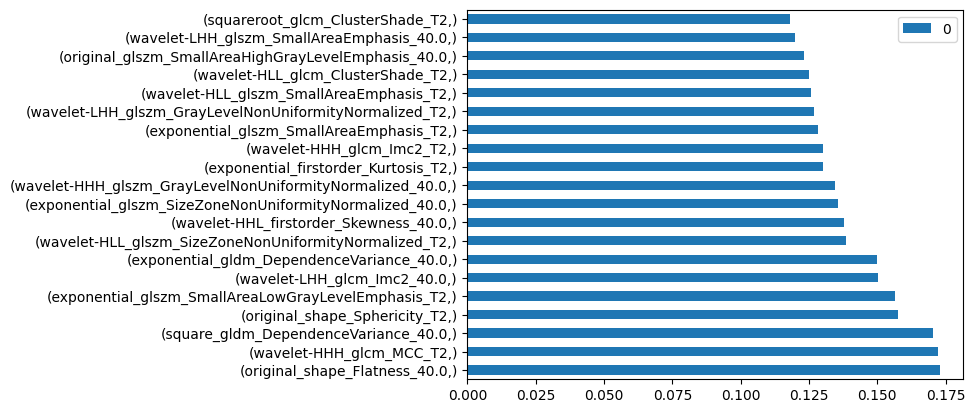

In [102]:
coeff_imp.T.sort_values(by=[0], ascending=False).iloc[:20].plot.barh()

In [17]:
def retrain_cv_for_roc_curve_display(model, X, y, kfolds):
    
    tprs = []
    aucs = []
    mean_fpr = np.linspace(0, 1, 100)

    fig, ax = plt.subplots()
    for i, (train, test) in enumerate(kfolds.split(X, y)):
        print(np.array(y)[train].shape)
        model.fit(np.array(X)[train], np.array(y)[train])
        viz = RocCurveDisplay.from_estimator(
            model,
            np.array(X)[test],
            np.array(y)[test],
            name="ROC fold {}".format(i),
            alpha=0.3,
            lw=1,
            ax=ax,
        )
        interp_tpr = np.interp(mean_fpr, viz.fpr, viz.tpr)
        interp_tpr[0] = 0.0
        tprs.append(interp_tpr)
        aucs.append(viz.roc_auc)

    ax.plot([0, 1], [0, 1], linestyle="--", lw=2, color="r", label="Chance", alpha=0.8)

    mean_tpr = np.mean(tprs, axis=0)
    mean_tpr[-1] = 1.0
    mean_auc = auc(mean_fpr, mean_tpr)
    std_auc = np.std(aucs)
    ax.plot(
        mean_fpr,
        mean_tpr,
        color="b",
        label=r"Mean ROC (AUC = %0.2f $\pm$ %0.2f)" % (mean_auc, std_auc),
        lw=2,
        alpha=0.8,
    )

    std_tpr = np.std(tprs, axis=0)
    tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
    tprs_lower = np.maximum(mean_tpr - std_tpr, 0)
    ax.fill_between(
        mean_fpr,
        tprs_lower,
        tprs_upper,
        color="grey",
        alpha=0.2,
        label=r"$\pm$ 1 std. dev.",
    )

    ax.set(
        xlim=[-0.05, 1.05],
        ylim=[-0.05, 1.05],
        title="Receiver operating characteristic example",
    )
    ax.legend(loc="lower right")
    plt.show()

(108,)
(109,)
(109,)
(109,)
(109,)


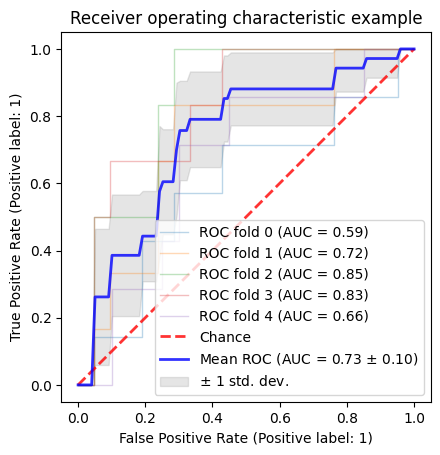

In [104]:
retrain_cv_for_roc_curve_display(search.best_estimator_, X_train_all_without_DCE, shape_target_train.values.ravel(), skf)

In [18]:
def return_kfold_score(model, to_fit, target, metric, kfolds, name=None):
    if metric == 'youden_index':
        score = round((cross_val_score(model, to_fit, target, scoring=make_scorer(recall_score), cv=kfolds, n_jobs=-1) + cross_val_score(model, to_fit, target, scoring=make_scorer(recall_score,pos_label=0), cv=kfolds, n_jobs=-1) -1).mean(), 2)
        std = round((cross_val_score(model, to_fit, target, scoring=make_scorer(recall_score), cv=kfolds, n_jobs=-1) + cross_val_score(model, to_fit, target, scoring=make_scorer(recall_score,pos_label=0), cv=kfolds, n_jobs=-1) -1).std(), 2)
    else:
        score = round(cross_val_score(model, to_fit, target, scoring=metric, cv=kfolds, n_jobs=-1).mean(), 2)
        std = round(cross_val_score(model, to_fit, target, scoring=metric, cv=kfolds, n_jobs=-1).std(), 2)

    return score, std

In [19]:
def compile_results(model, X, y, kfolds, return_bool=None):
    print('auc')
    auc, auc_std = return_kfold_score(model, X, y, 'roc_auc', kfolds)
    print('ba')
    balanced_accuracy, balanced_accuracy_std = return_kfold_score(model, X, y, 'balanced_accuracy', kfolds)
    print('prec')
    precision, precision_std = return_kfold_score(model, X, y, 'precision', kfolds)
    print('recall')
    recall, recall_std = return_kfold_score(model, X, y, 'recall', kfolds)
    print('f1')
    f1, f1_std = return_kfold_score(model, X, y, 'f1', kfolds)

    scoring = {
        'sensitivity': make_scorer(recall_score),
        'specificity': make_scorer(recall_score,pos_label=0)
    }
    print('spec')
    specificity, specificity_std = return_kfold_score(model, X, y, scoring['specificity'], kfolds, 'specificity')
    print('sens')
    sensitivity, sensitivity_std = return_kfold_score(model, X, y, scoring['sensitivity'], kfolds, 'sensitivity')
    youden_index , youden_index_std = return_kfold_score(model, X, y, 'youden_index', kfolds, 'youden_index')

    if return_bool is None:
        for x in [('auc', auc, auc_std), ('balanced_acc', balanced_accuracy, balanced_accuracy_std), ('precision', precision, precision_std), ('recall', recall, recall_std), ('f1', f1, f1_std), ('specificity', specificity, specificity_std), ('sensitivity', sensitivity, sensitivity_std), ('youden_index', youden_index, youden_index_std)]:       
            print(str(x[0]) + ' ' + str(str(x[1])) + ' +/- ' + str(x[2]))

    if return_bool:

        return [(auc, auc_std), (balanced_accuracy, balanced_accuracy_std), (precision, precision_std), (recall, recall_std), (f1, f1_std), (specificity, specificity_std), (sensitivity, sensitivity_std), (youden_index, youden_index_std)]

In [113]:
comp_results = [compile_results(search.best_estimator_, X_train_all_without_DCE, shape_target_train.values.ravel(), skf, True)]
results = pd.DataFrame(comp_results, index=['Logistic Regression Shape'], columns=['roc_auc', 'balanced_accuracy', 'precision', 'recall', 'f1', 'specificity', 'sensitivity', 'youden_index']).T

auc
ba
prec
recall
f1
spec
sens


In [114]:
results

,Logistic Regression Shape
roc_auc,"(0.73, 0.1)"
balanced_accuracy,"(0.72, 0.09)"
precision,"(0.42, 0.05)"
recall,"(0.8, 0.21)"
f1,"(0.54, 0.09)"
specificity,"(0.67, 0.05)"
sensitivity,"(0.8, 0.22)"
youden_index,"(0.44, 0.18)"


In [5]:
pipe = Pipeline([('scaler', StandardScaler()), ('logistic', LogisticRegression(solver='saga', max_iter = 10000))])

In [6]:
skf_out = StratifiedKFold(n_splits=10, random_state=123, shuffle=True)
skf_in = StratifiedKFold(n_splits=5, random_state=123, shuffle=True)
params_grid = {
            #'logistic__class_weight': [{0:0.05, 1:0.95}, {0:0.1, 1:0.9}, {0:0.2, 1:0.8}, {0:0.3, 1:0.7}, {0:0.4, 1:0.6}, {0:0.5, 1:0.5}],
            'logistic__penalty': ['elasticnet'],
            'logistic__C': np.logspace(-2, 0.5, 20),
            'logistic__l1_ratio' : np.arange(0 , 1.1 , 0.1)
                    }

ncv = NestedCV(estimator = pipe, params = params_grid , cv_inner = skf_in, cv_outer = skf_out, 
               scoring_inner = 'f1' , scoring_outer = {'roc_auc': 'roc_auc', 'balanced_accuracy': 'balanced_accuracy', 'precision': 'precision', 'recall': 'recall', 'f1': 'f1'},#, 'specificity': 'specificity', 'sensitivity': 'sensitivity'},
               library = 'dask' , scheduler = client, verbose=2, randomized=True)

In [7]:
start = time.time()
ncv.fit(X_train_all_without_DCE, margins_target_train.values.ravel())
end = time.time()
minutes, seconds = divmod(end - start, 60)
print("Total fitting time (min): " + "{:0>2}:{:05.2f}".format(int(minutes),seconds))

inner training out fold 0 done ! running time (min): 00:15.73
inner training out fold 1 done ! running time (min): 00:16.19
inner training out fold 2 done ! running time (min): 00:14.78
inner training out fold 3 done ! running time (min): 00:19.33
inner training out fold 4 done ! running time (min): 00:19.84
inner training out fold 5 done ! running time (min): 00:20.95
inner training out fold 6 done ! running time (min): 00:19.57
inner training out fold 7 done ! running time (min): 00:17.66
inner training out fold 8 done ! running time (min): 00:19.22
inner training out fold 9 done ! running time (min): 00:16.77
Total fitting time (min): 03:18.98


In [8]:
client.close()

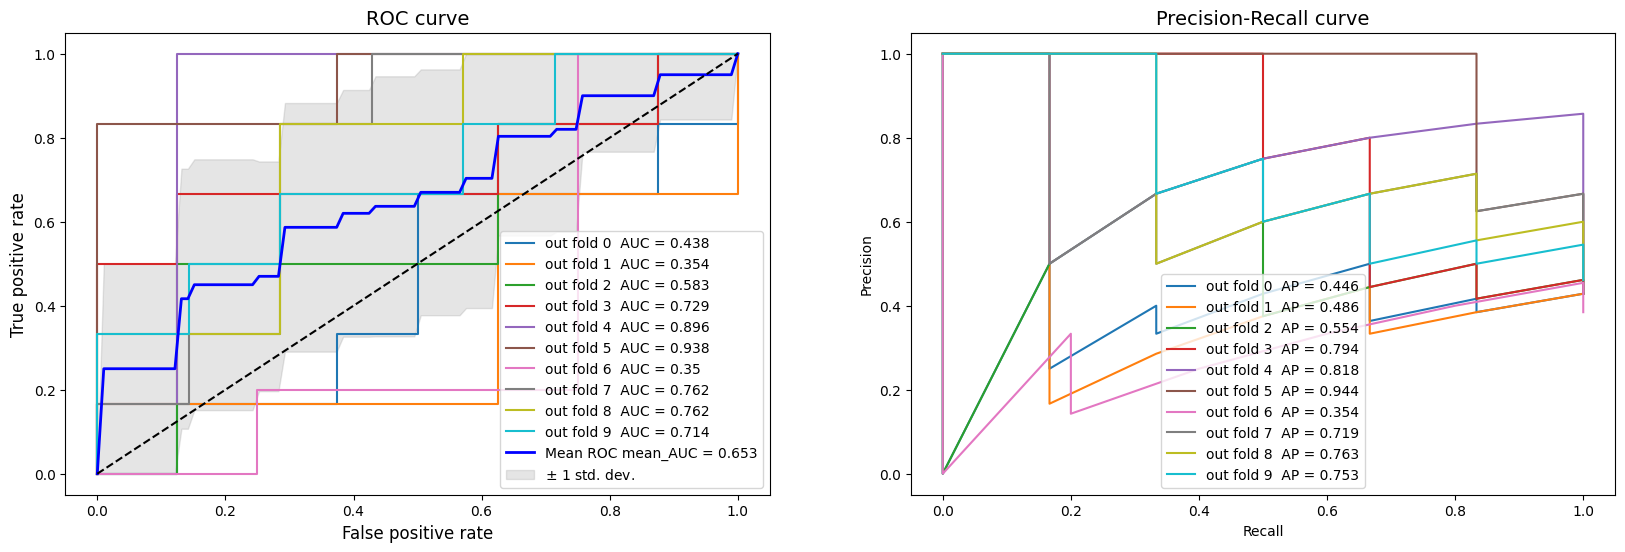

In [9]:
fig , axes = plt.subplots(1 , 2 , figsize = (20, 6))
plot_roc(ncv , ax = axes[0])
plot_PR(ncv , ax = axes[1])

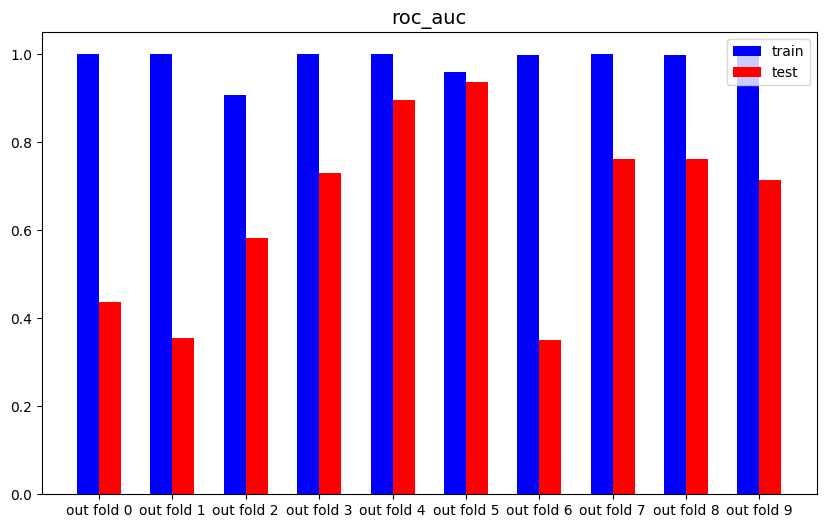

In [10]:
plot_score(ncv , score_name = 'roc_auc' , display = 'barplot')

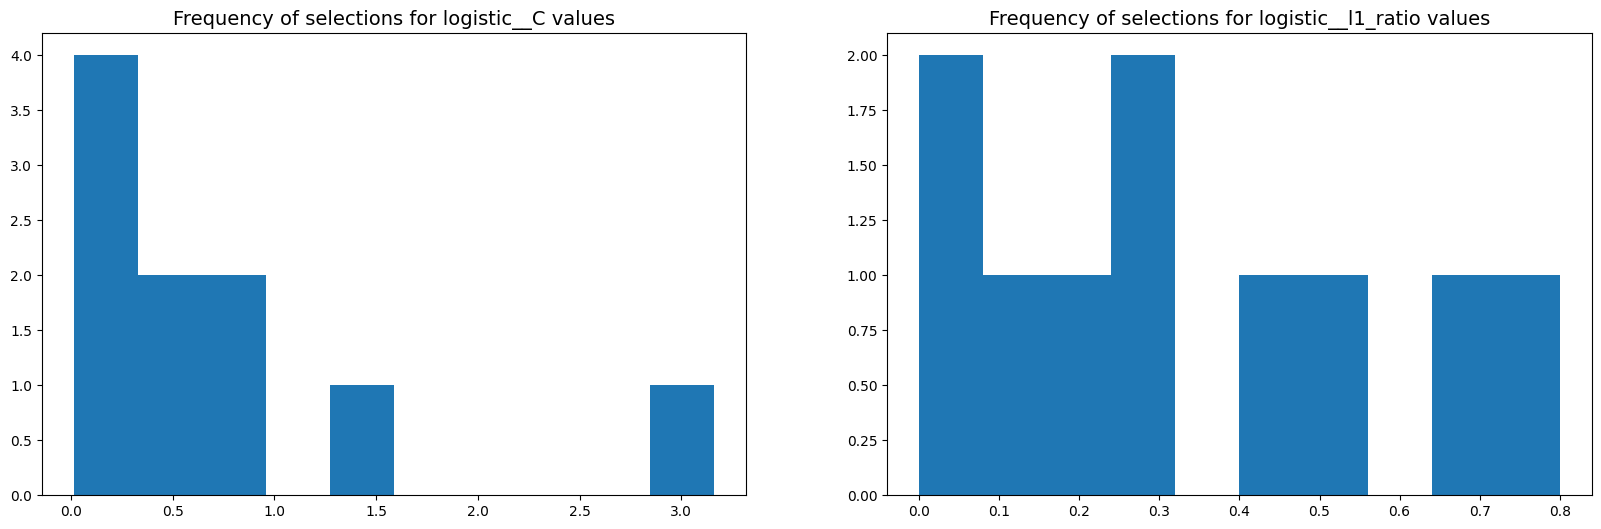

In [12]:
fig , ax = plt.subplots(1 , 2 , figsize = (20 , 6))
plot_hyperparameters(ncv , name = 'logistic__C' , discrete = False, ax = ax[0])
#ax[0].set_xlim([5, 10])
plot_hyperparameters(ncv , name = 'logistic__l1_ratio' , discrete = False , ax = ax[1])
#plot_hyperparameters(ncv , name = 'logistic__class_weight' ,  ax = ax[2])


In [24]:
ncv.best_params_

[{'logistic__penalty': 'elasticnet',
  'logistic__l1_ratio': 0.1,
  'logistic__class_weight': {0: 0.4, 1: 0.6},
  'logistic__C': 0.20691380811147891},
 {'logistic__penalty': 'elasticnet',
  'logistic__l1_ratio': 0.5,
  'logistic__class_weight': {0: 0.4, 1: 0.6},
  'logistic__C': 2.335721469090121},
 {'logistic__penalty': 'elasticnet',
  'logistic__l1_ratio': 0.0,
  'logistic__class_weight': {0: 0.3, 1: 0.7},
  'logistic__C': 0.2801356761198867},
 {'logistic__penalty': 'elasticnet',
  'logistic__l1_ratio': 0.0,
  'logistic__class_weight': {0: 0.5, 1: 0.5},
  'logistic__C': 0.20691380811147891},
 {'logistic__penalty': 'elasticnet',
  'logistic__l1_ratio': 0.2,
  'logistic__class_weight': {0: 0.3, 1: 0.7},
  'logistic__C': 0.04548777947003778},
 {'logistic__penalty': 'elasticnet',
  'logistic__l1_ratio': 0.0,
  'logistic__class_weight': {0: 0.3, 1: 0.7},
  'logistic__C': 0.018329807108324356},
 {'logistic__penalty': 'elasticnet',
  'logistic__l1_ratio': 0.7000000000000001,
  'logistic__cl

In [26]:
skf = StratifiedKFold(n_splits=5, random_state=123, shuffle=True)
params_grid = {
            #'logistic__class_weight': [{0:0.05, 1:0.95}, {0:0.1, 1:0.9}, {0:0.2, 1:0.8}],# {0:0.3, 1:0.7}, {0:0.4, 1:0.6}, {0:0.5, 1:0.5}],
            'logistic__penalty': ['elasticnet'],
            'logistic__C': np.logspace(-2, 0.5, 20),
            'logistic__l1_ratio' : np.arange(0 , 1.1 , 0.1)
                    }
optimized_new_pipe = Pipeline([('scaler', StandardScaler()), ('logistic', LogisticRegression(solver='saga', max_iter = 100000))])
search = GridSearchCV(optimized_new_pipe, params_grid, cv=skf, n_jobs=-1, verbose=1, scoring='f1')
search.fit(X_train_all_without_DCE, margins_target_train.values.ravel())

Fitting 5 folds for each of 220 candidates, totalling 1100 fits


GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=123, shuffle=True),
             estimator=Pipeline(steps=[('scaler', StandardScaler()),
                                       ('logistic',
                                        LogisticRegression(max_iter=100000,
                                                           solver='saga'))]),
             n_jobs=-1,
             param_grid={'logistic__C': array([0.01      , 0.01353876, 0.01832981, 0.02481629, 0.03359818,
       0.04548778, 0.06158482, 0.08337822, 0.11288379, 0.15283067,
       0.20691381, 0.28013568, 0.37926902, 0.51348329, 0.6951928 ,
       0.94120497, 1.27427499, 1.72521055, 2.33572147, 3.16227766]),
                         'logistic__l1_ratio': array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
                         'logistic__penalty': ['elasticnet']},
             scoring='f1', verbose=1)

In [27]:
search.best_params_

{'logistic__C': 0.08337822234717891,
 'logistic__l1_ratio': 0.6000000000000001,
 'logistic__penalty': 'elasticnet'}

Pipeline(steps=[('scaler', StandardScaler()),
                ('logistic',
                 LogisticRegression(C=0.08337822234717891,
                                    l1_ratio=0.6000000000000001,
                                    max_iter=100000, penalty='elasticnet',
                                    solver='saga'))])
sensitivity: 0.7368421052631579
specificity: 0.45161290322580644
youden_index: 0.18845500848896424
balanced_accuracy: 0.5942275042444821
roc_auc: 0.5942275042444822
precision: 0.45161290322580644
recall: 0.7368421052631579
              precision    recall  f1-score   support

           0       0.74      0.45      0.56        31
           1       0.45      0.74      0.56        19

    accuracy                           0.56        50
   macro avg       0.59      0.59      0.56        50
weighted avg       0.63      0.56      0.56        50



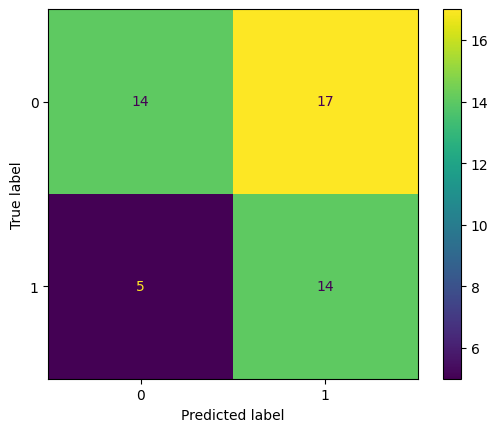

In [28]:
for model in [search.best_estimator_]:
    scoring = {
    'sensitivity': make_scorer(recall_score),
    'specificity': make_scorer(recall_score,pos_label=0),
    'balanced_accuracy': make_scorer(balanced_accuracy_score),
    'roc_auc': make_scorer(roc_auc_score),
    'precision': make_scorer(precision_score),
    'recall': make_scorer(recall_score),
    'precision_recall_f': make_scorer(precision_recall_fscore_support)
    }

    if model == search.best_estimator_:
        y_pred = compute_pred(model, X_eval_all)
        print(model)
        print('sensitivity: ' + str(scoring['sensitivity'](model, X_eval_all, margins_target_eval)))
        print('specificity: ' + str(scoring['specificity'](model, X_eval_all, margins_target_eval)))
        print('youden_index: ' + str(scoring['specificity'](model, X_eval_all, margins_target_eval)+ scoring['sensitivity'](model, X_eval_all, margins_target_eval) - 1))
        print('balanced_accuracy: ' + str(scoring['balanced_accuracy'](model, X_eval_all, margins_target_eval)))
        print('roc_auc: ' + str(scoring['roc_auc'](model, X_eval_all, margins_target_eval)))
        print('precision: ' + str(scoring['precision'](model, X_eval_all, margins_target_eval)))
        print('recall: ' + str(scoring['recall'](model, X_eval_all, margins_target_eval)))

        print(classification_report(margins_target_eval.values.ravel(), y_pred))
        cm = confusion_matrix(margins_target_eval.values.ravel(), y_pred, labels=model.classes_)
        disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                                    display_labels=model.classes_)
        disp.plot()

(108,)
(109,)
(109,)
(109,)
(109,)


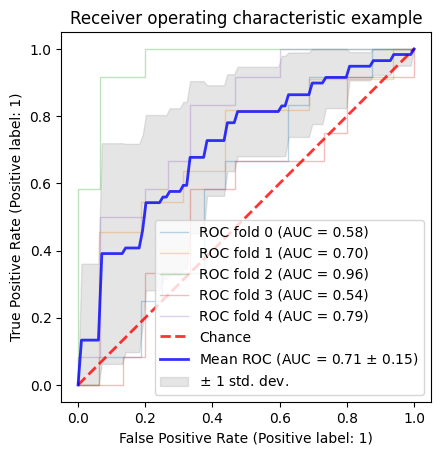

In [29]:
retrain_cv_for_roc_curve_display(search.best_estimator_, X_train_all_without_DCE, margins_target_train.values.ravel(), skf)

In [30]:
comp_results = [compile_results(search.best_estimator_, X_train_all_without_DCE, margins_target_train.values.ravel(), skf, True)]
results = pd.DataFrame(comp_results, index=['Logistic Regression Margins'], columns=['roc_auc', 'balanced_accuracy', 'precision', 'recall', 'f1', 'specificity', 'sensitivity', 'youden_index']).T

auc
ba
prec
recall
f1
spec
sens


In [31]:
results

,Logistic Regression Margins
roc_auc,"(0.71, 0.15)"
balanced_accuracy,"(0.66, 0.13)"
precision,"(0.66, 0.18)"
recall,"(0.54, 0.18)"
f1,"(0.59, 0.16)"
specificity,"(0.78, 0.12)"
sensitivity,"(0.54, 0.18)"
youden_index,"(0.33, 0.25)"
